# Cell-Annotation

###  Cell annotation by large language model GPT-4
Hou, W., Ji, Z. Assessing GPT-4 for cell type annotation in single-cell RNA-seq analysis. Nat Methods 21, 1462–1465 (2024). https://doi.org/10.1038/s41592-024-02235-4

In [1]:
import scanpy as sc
from cell_annotator import CellAnnotator
import pandas as pd
import numpy as np
import glob
import os
import tqdm

/home/raquelcr/.conda/envs/cellann/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Gene Orthology Reference


In [3]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv('/home/raquelcr/NMR-snRNA-seq/orthology/nmr_human_orthology.csv')
print(gene_reference.shape)
gene_reference.head()


(14981, 10)


,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17


## Load NMR data 

In [82]:
nmr_data = sc.read('/home/raquelcr/scanpy/ann_datasets/nmr_adatas8.h5ad')
nmr_data

AnnData object with n_obs × n_vars = 66126 × 20774
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region'
    var: 'chromosome', 'feature_types', 'gene_ids', 'genome', 'global_name', 'species'

In [83]:
# Preserve current gene names
nmr_data.var['nmr_gene_name'] = nmr_data.var_names

# Replace var_names safely with human gene names
nmr_data.var_names = nmr_data.var['global_name'].astype(str)
nmr_data.var_names_make_unique()  # ensure uniqueness, Scanpy-safe

/home/raquelcr/.local/lib/python3.10/site-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['RPS3A-1']
  warnings.warn(


### Load few cells from human (adult and developing human) to perform cross-validation by triangulation

In [36]:
human_data = sc.read('/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad_subset2.h5ad')
dev_human = sc.read('/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad_subset2.h5ad')

Only considering the two last: ['.h5ad_subset2', '.h5ad'].
Only considering the two last: ['.h5ad_subset2', '.h5ad'].


In [39]:
gene_reference

,human_gene_name,human_gene_acc,nmr_gene_name,nmr_gene_acc,perc_id,orthology_type,human_name_rep,nmr_name_rep,human_chr,nmr_chr
0,A2M,ENSG00000175899,A2m,ENSHGLG00000000871,77.7476,ortholog_one2one,1.0,1.0,12,5
1,A3GALT2,ENSG00000184389,A3GALT2,ENSHGLG00000012021,78.2353,ortholog_one2one,1.0,1.0,1,7
2,A4GALT,ENSG00000128274,A4GALT,ENSHGLG00000048655,77.0538,ortholog_one2one,1.0,1.0,22,5
3,A4GNT,ENSG00000118017,A4GNT,ENSHGLG00000014457,79.3510,ortholog_one2one,1.0,1.0,3,8
4,AAAS,ENSG00000094914,AAAS,ENSHGLG00000002843,93.0147,ortholog_one2one,2.0,1.0,12,17
...,...,...,...,...,...,...,...,...,...,...
14976,TNFRSF11B,ENSG00000164761,TNFRSF11B,ENSHGLG00000004624,86.5337,ortholog_one2one,1.0,1.0,8,21
14977,TRAP1,ENSG00000126602,TRAP1,ENSHGLG00000010156,89.2045,ortholog_one2one,1.0,1.0,16,23
14978,VIP,ENSG00000146469,VIP,ENSHGLG00000003764,84.1176,ortholog_one2one,1.0,1.0,6,1
14979,ZNF689,ENSG00000156853,ZNF689,ENSHGLG00000009540,94.2000,ortholog_one2one,1.0,1.0,16,23


In [40]:
# Map human
human_gene_map = dict(zip(gene_reference['human_gene_acc'], gene_reference['human_gene_name']))

human_data.var['global_name'] = human_data.var_names.map(human_gene_map)
dev_human.var['global_name'] = dev_human.var['Accession'].map(human_gene_map)
nmr_data.var['global_name'] = nmr_data.var['gene_ids'].map(
    dict(zip(gene_reference['nmr_gene_acc'], gene_reference['human_gene_name']))
)

In [42]:
# Set global names as var_names
for adata in [human_data, dev_human, nmr_data]:
    adata.var_names = adata.var['global_name'].astype(str)
    adata.var_names_make_unique()

In [43]:
shared_genes = list(
    set(human_data.var_names)
    & set(dev_human.var_names)
    & set(nmr_data.var_names)
)
for adata in [human_data, dev_human, nmr_data]:
    adata._inplace_subset_var([g in shared_genes for g in adata.var_names])


In [44]:
import scanpy as sc

for adata in [human_data, dev_human, nmr_data]:
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)


In [45]:
adata_merged = sc.concat(
    [human_data, dev_human, nmr_data],
    label="species",
    keys=["human_adult", "human_dev", "nmr"],
    join="outer",
    index_unique="-"
)


In [49]:
import numpy as np

hvgs = []
for adata in [human_data, dev_human, nmr_data]:
    sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    hvgs.append(set(adata.var[adata.var['highly_variable']].index))

shared_hvgs = list(set.union(*hvgs))
adata_merged = adata_merged[:, shared_hvgs]


In [50]:
sc.pp.scale(adata_merged, max_value=10)
sc.tl.pca(adata_merged, svd_solver='arpack', n_comps=50)


/home/raquelcr/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
adata_merged.obs

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,...,cell_cycle_score,total_genes,species,tissue,replicate,sample,region,init_leiden,_scvi_batch,_scvi_labels
10X206_1:CAGATACTCGCATAGT-human_adult,Head of hippocampus (HiH) - Uncal CA1,4488.0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,...,NaN,NaN,human_adult,NaN,NaN,NaN,NaN,NaN,0,0
10X175_8:TGCTCCAGTTGTGTAC-human_adult,Midbrain (M) - Substantia Nigra - SN,3244.0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,...,NaN,NaN,human_adult,NaN,NaN,NaN,NaN,NaN,0,0
10X176_1:TGGAGAGGTTAGCGGA-human_adult,"Midbrain (M) - Substantia Nigra, Red Nucleus, ...",3537.0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,...,NaN,NaN,human_adult,NaN,NaN,NaN,NaN,NaN,0,0
10X230_6:CTCCCTCGTCGCATGC-human_adult,Body of hippocampus (HiB) - Rostral DG-CA4,3885.0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,...,NaN,NaN,human_adult,NaN,NaN,NaN,NaN,NaN,0,0
10X175_7:CACTGGGGTAGCGTAG-human_adult,Midbrain (M) - Substantia Nigra - SN,3161.0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,...,NaN,NaN,human_adult,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTAGGCAAGAACGCGT-1-NMR6-nmr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nmr,midbrain,2.0,NMR6,midbrain,0,2,0
ATTCCATTCTATTGTC-1-NMR6-nmr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nmr,midbrain,2.0,NMR6,midbrain,0,2,0
GTCATGACAGCTGAGA-1-NMR6-nmr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nmr,midbrain,2.0,NMR6,midbrain,12,2,0
CCGGTAGCATGGACAG-1-NMR6-nmr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nmr,midbrain,2.0,NMR6,midbrain,0,2,0


In [51]:
import scvi

# Prepare scVI model
scvi.model.SCVI.setup_anndata(adata_merged, batch_key="species")
vae = scvi.model.SCVI(adata_merged, n_latent=30)
vae.train()

# Transfer cell type labels for human datasets
adata_merged.obs['cell_type'] = adata_merged.obs['cell_type'].astype('category')

# Setup scANVI model using labeled + unlabeled cells
labeled = adata_merged.obs['cell_type'].notna()
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae, 
    unlabeled_category="Unknown",
    labels_key="cell_type"
)
scanvi_model.train(max_epochs=100)

# Save integrated latent representation
adata_merged.obsm["X_scANVI"] = scanvi_model.get_latent_representation()


/home/raquelcr/.conda/envs/cellann/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/raquelcr/.conda/envs/cellann/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Epoch 1/232:   0%|          | 0/232 [00:00<?, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (128, 30)) of distribution Normal(loc: torch.Size([128, 30]), scale: torch.Size([128, 30])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AddmmBackward0>)

In [ ]:
sc.pp.neighbors(adata_merged, use_rep="X_scANVI", n_neighbors=15)
sc.tl.umap(adata_merged)
sc.tl.leiden(adata_merged, resolution=0.6)

sc.pl.umap(adata_merged, color=["species", "cell_type", "leiden"], wspace=0.4)


In [ ]:
from scib.metrics import ilisi_graph, clisi_graph

lisi_score = ilisi_graph(adata_merged, batch_key="species")
print("iLISI score:", np.mean(lisi_score))


In [ ]:
from cell_annotator import GPTAnnotator

annotator = GPTAnnotator(model="gpt-4o")  # or "gpt-5"
annotator.annotate(
    adata_merged,
    features="var_names",
    clusters="leiden",
    prompt="Annotate cross-species brain cell clusters (human, developing, and NMR)."
)


## Pre-process

In [54]:
nmr_data

AnnData object with n_obs × n_vars = 24028 × 8045
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'init_leiden', 'n_genes'
    var: 'chromosome', 'feature_types', 'gene_ids', 'genome', 'global_name', 'species', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'init_leiden', 'tissue_colors', 'init_leiden_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [84]:
human_ribo_genes = pd.read_csv('/home/raquelcr/scanpy/human_ribo_genes.csv', header=1)
human_ribo_genes = human_ribo_genes['Approved symbol'].tolist()
len(human_ribo_genes)

247

In [85]:
nmr_data.var["mt"] = nmr_data.var_names.str.startswith(("mt-", "MT-","Mt-"))
print(f'Found {nmr_data.var["mt"].sum()} mito genes.')
nmr_data.var["ribo"] = [name in human_ribo_genes for name in nmr_data.var_names]
print(f'Found {nmr_data.var["ribo"].sum()} ribo genes.\n')
sc.pp.calculate_qc_metrics(nmr_data, qc_vars=["mt", "ribo"], inplace=True)


Found 11 mito genes.
Found 139 ribo genes.



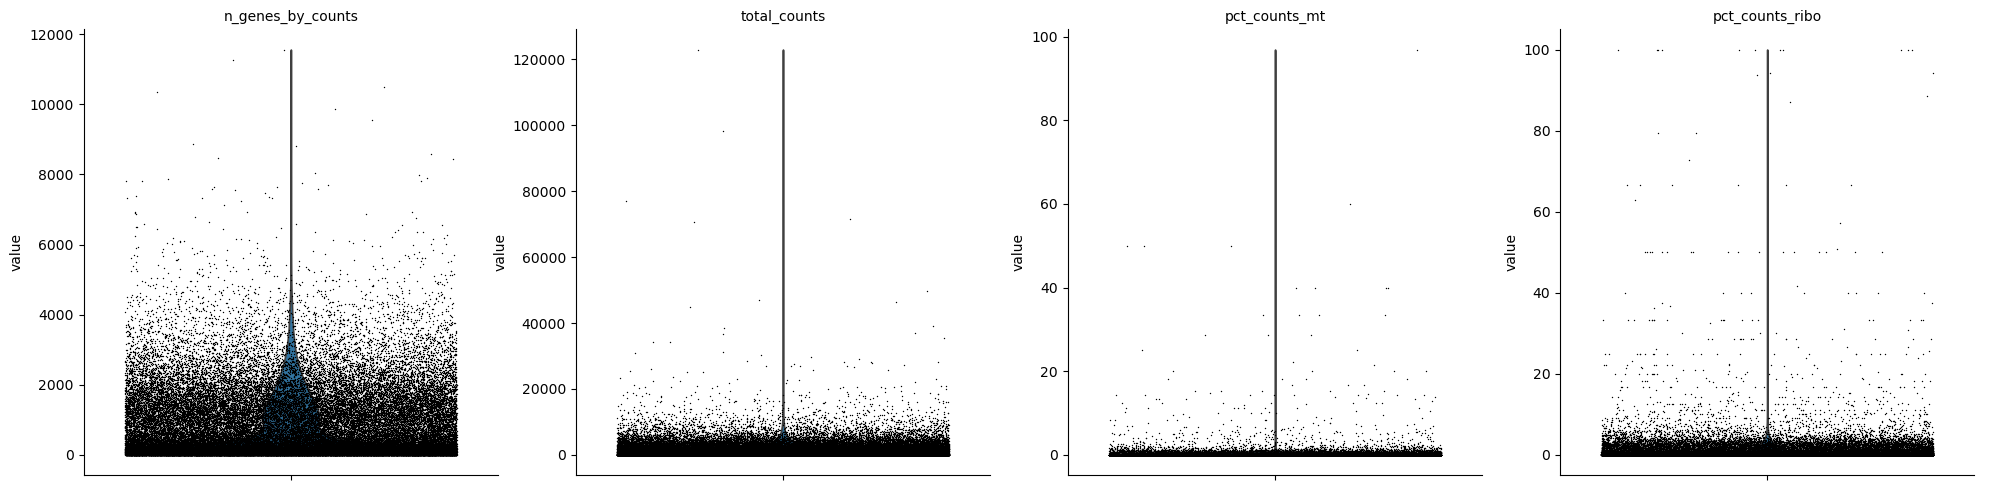

In [86]:
sc.pl.violin(
        nmr_data,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [87]:
# Filter out low-quality cells in nmr data
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] > 4,:]
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] < 10,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < 3,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_ribo'] < 7,:]
nmr_data.shape

(57155, 20774)

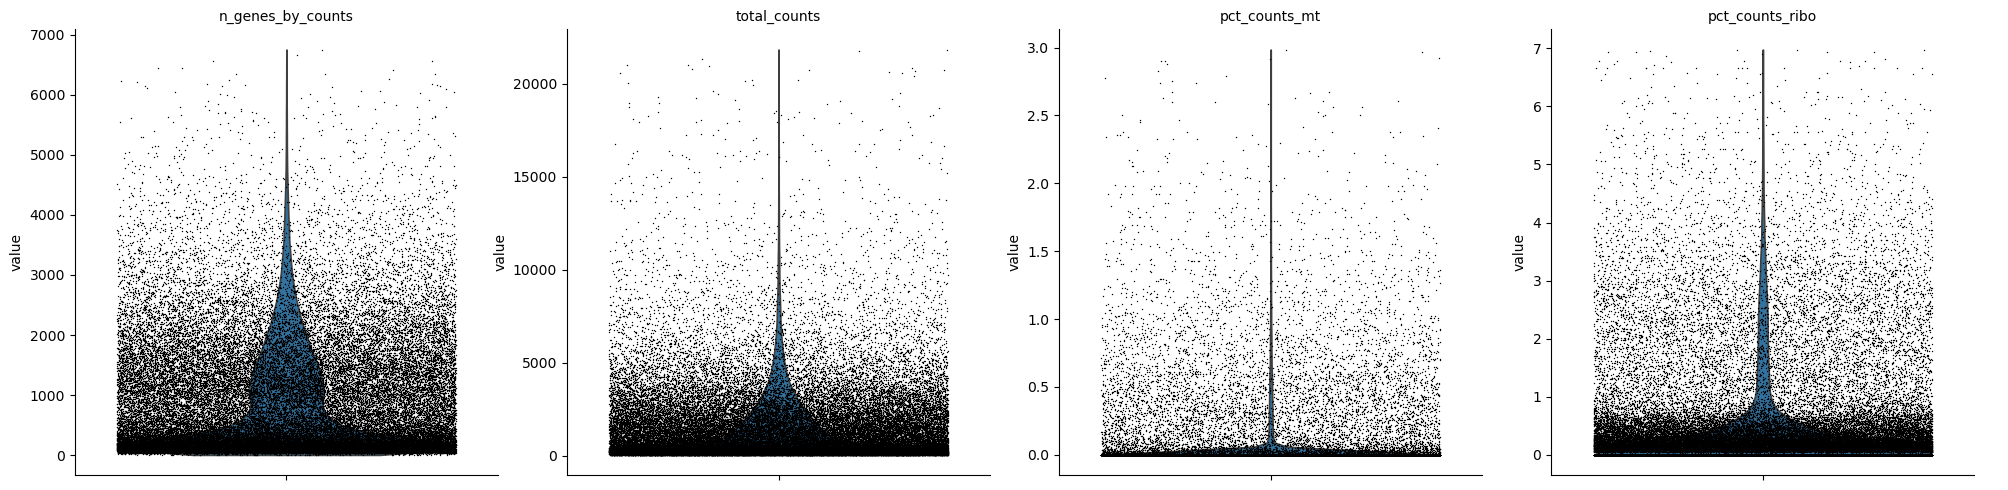

In [88]:
sc.pl.violin(
        nmr_data,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

## Normalize

In [89]:
sc.pp.normalize_per_cell(nmr_data)
sc.pp.log1p(nmr_data)

/tmp/ipykernel_3488082/1822374834.py:1: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(nmr_data)
/home/raquelcr/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:585: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/home/raquelcr/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:588: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


# HGV

In [90]:
sc.pp.highly_variable_genes(nmr_data, n_top_genes=3000)

In [91]:
sc.pp.scale(nmr_data, max_value=10)

## PCA

In [92]:
sc.tl.pca(nmr_data, n_comps=50, svd_solver='arpack')

## Neihbors & Clustering

In [ ]:
# 1. Initial clustering + marker inspection
sc.pp.neighbors(nmr_data, use_rep='X_pca', n_neighbors=30, n_pcs=40)
sc.tl.umap(nmr_data)
resolutions = [0.8,1,1.2]
for res in resolutions:
    sc.tl.leiden(nmr_data, resolution=res, key_added=f'leiden_{res}')


In [ ]:
nmr_data.obsm

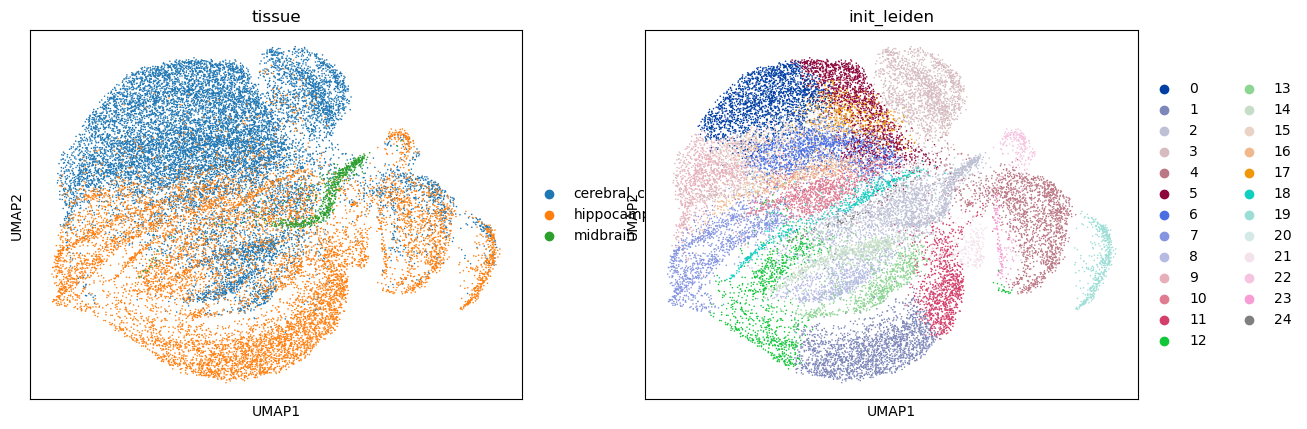

In [ ]:
sc.pl.umap(nmr_data, color=['tissue','leiden_0.8','leiden_1.0','leiden_1.2'])

## GPT-Cell-Annotation

In [ ]:
from cell_annotator import CellAnnotator


TypeError: CellAnnotator.__init__() missing 3 required positional arguments: 'adata', 'species', and 'tissue'

In [73]:
import openai

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = 
from cell_annotator import CellAnnotator


In [81]:
cell_ann = CellAnnotator(nmr_data, 
                         species="merged", 
                         cluster_key="init_leiden", 
                         sample_key="species",
                         tissue="crebral_cortex OR hippocampus OR midbrain",
                         api_key=os.getenv("OPENAI_API_KEY"),
                         model="gpt-5")
cell_ann = cell_ann.annotate_clusters()
nmr_data.obs['cell_type_init'] = cell_ann.obs['cell_type_predicted']


INFO     Initializing `1` SampleAnnotator objects(s).                                                              
INFO     Querying cell types.                                                                                      


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
cell_ann = CellAnnotator(
    adata, species="human", tissue="brain", cluster_key="leiden", sample_key="samples",
).annotate_clusters()